In [ ]:
#### Spacecraft Anomally Project ####

In [179]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as seaborn

# read the data sets
anom_data = pd.read_csv(r'anomaly.csv',na_values='missing')
tdr_data = pd.read_csv(r'tdrs5j.csv',na_values='missing')

# concatenate the data sets
anom_data = pd.concat([anom_data.copy(),tdr_data],axis=0)


In [180]:
# Turn the date columns into date objects
anom_data.ADATE = pd.to_datetime(anom_data.ADATE,format='%m/%d/%Y')
anom_data.EDATE = pd.to_datetime(anom_data.EDATE,format='%m/%d/%Y')

# Turn lowercase to uppercase
for i in anom_data.ORBIT:
    letter = i
    if letter.islower() == True:
        i = letter.upper()

# drop rows that have missing orbits and anomally types
anom_data = anom_data[anom_data.ATYPE != 'missing']
anom_data = anom_data[anom_data.ORBIT != 'missing']
anom_data = anom_data[anom_data.SVE != 'missing']

# turn categorical variables into discrete variables
# diagnosis, orbit type, earth sun degrees, anomally type
sort_adiag = sorted(set(anom_data.ADIAG))
sort_orbit = sorted(set(anom_data.ORBIT))
sort_atype = sorted(set(anom_data.ATYPE))

# create a dictionary for each column
def make_dict(column):
    d = {}
    count = 0
    for i in column:
        count+=1
        d[i] = count
    return d
dict_atype = make_dict(sort_atype)
dict_adiag = make_dict(sort_adiag)
dict_orbit = make_dict(sort_orbit)

# map the values
anom_data['ADIAG'].replace(dict_adiag, inplace=True)
anom_data['ATYPE'].replace(dict_atype, inplace=True)
anom_data['ORBIT'].replace(dict_orbit, inplace=True)

# bin the sun-earth degrees
bins = {}
#anom_data.SVE = pd.cut(anom_data.SVE,2)
count = 0
# j in sorted(anom_data.SVE.unique()):
#    count+=1
#    bins[j]=count
#anom_data.replace({'SVE':bins},inplace=True)

In [181]:
anom_data.shape[0]

5620

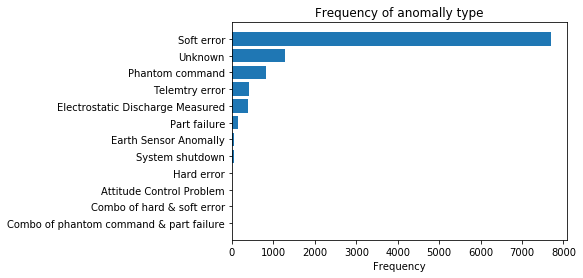

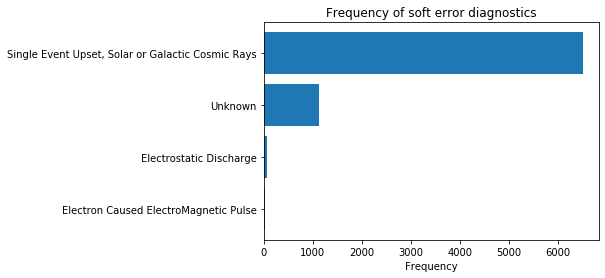

In [102]:
### Exploratory Analysis / Descriptive Analysis ###
anom_dict = {'SE':'Soft error', 'UNK':'Unknown','PC':'Phantom command','TE':'Telemtry error','ESDM':'Electrostatic Discharge Measured', 
            'PF':'Part failure','missing':'Earth Sensor Anomally','SS':'System shutdown','HE':'Hard error','ATT':'Attitude Control Problem',
            'SE/HE':'Combo of hard & soft error','PC/PF':'Combo of phantom command & part failure'}

# How many anomalies of each type
%matplotlib inline
fig, ax = plt.subplots()
anom_type = ['Soft error', 'Unknown','Phantom command','Telemtry error','Electrostatic Discharge Measured', 
            'Part failure','Earth Sensor Anomally','System shutdown','Hard error','Attitude Control Problem',
            'Combo of hard & soft error','Combo of phantom command & part failure']
y_pos = np.arange(len(anom_type))
ax.barh(y_pos, anom_data['ATYPE'].value_counts(), align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(anom_type)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Frequency')
ax.set_title('Frequency of anomally type')
plt.show()

# What is causing soft error anomalies
se_anom_diag = ['Single Event Upset, Solar or Galactic Cosmic Rays', 
               'Unknown', 'Electrostatic Discharge', 'Electron Caused ElectroMagnetic Pulse']
y_pos = np.arange(len(se_anom_diag))
fig,ax = plt.subplots()
ax.barh(y_pos, anom_data.loc[anom_data.ATYPE=='SE','ADIAG'].value_counts(), align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(se_anom_diag)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Frequency')
ax.set_title('Frequency of soft error diagnostics')
plt.show()

# Difference between orbit types
orbit_data = anom_data.loc[:,['ATYPE','ORBIT']]
orbit_data_counts = orbit_data.groupby(by=[orbit_data.ATYPE,anom_data.ORBIT]).count()
orbit_data_counts.columns= ['Counts']
orbit_data_counts.reset_index(inplace=True)



In [100]:
orbit_data = anom_data.loc[:,['ATYPE','ORBIT']]
orbit_data_counts = orbit_data.groupby(by=[orbit_data.ATYPE,anom_data.ORBIT]).count()
orbit_data_counts.columns= ['Counts']
orbit_data_counts.reset_index(inplace=True)

# make barplot 
fig,ax = plt.subplots()


In [104]:
orbit_data_counts

,ATYPE,ORBIT,Counts
0,ATT,missing,3
1,ESDM,E,316
2,ESDM,G,41
3,ESDM,missing,20
4,HE,G,7
5,PC,E,1
6,PC,G,803
7,PC,P,12
8,PC,missing,5
9,PC/PF,G,1


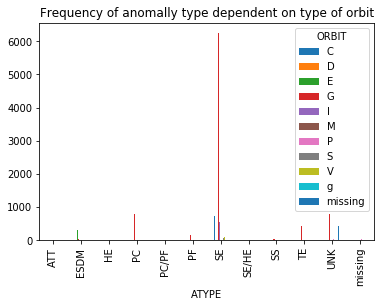

In [107]:
orbit_data_counts.pivot('ATYPE','ORBIT','Counts').plot(kind='bar', title='Frequency of anomally type dependent on type of orbit')

In [186]:
# Train test split
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

features = ['ORBIT','SVE','ADIAG']
label = 'ATYPE'

# Split the data into training and testing
xtrain, xtest, ytrain, ytest = train_test_split(anom_data[features], anom_data[label], test_size=0.20, random_state=42)

# Split the data again into training and validation
xtrain2, xvalid, ytrain2, yvalid = train_test_split(xtrain,ytrain,test_size=0.20,random_state=42)

nb_model = MultinomialNB()
nb_model.fit(xtrain2,ytrain2)
ypred = nb_model.predict(xvalid)
print('Training accuracy:', round(metrics.accuracy_score(yvalid, ypred),2))

nb_model.fit(xtest,ytest)
ypred_test = nb_model.predict(xtest)
print('Testing accuarcy:',round(metrics.accuracy_score(ytest,ypred_test),2))


Training accuracy: 0.19
testing accuarcy: 0.2
